# Load Python packages

In [1]:
# Load packages
# Established packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Custom package covid19model
from covid19model.models import models
from covid19model.data import model_parameters, mobility #, sciensano, google
from covid19model.models.utils import initialize_COVID19_SEIQRD_spatial_hybrid_vacc, read_coordinates_place, initial_state
from covid19model.models.time_dependant_parameter_fncs import make_mobility_update_function, make_VOC_function
from covid19model.visualization.output import *

# OPTIONAL: Load the "autoreload" extension so that package code can change
%load_ext autoreload
# OPTIONAL: always reload modules so that as you change code in src, it gets loaded
# This may be useful because the `covid19model` package is under construction
%autoreload 2

In [2]:
# Spatial model settings
agg = 'prov'
space_stratification_size = len(read_coordinates_place(agg=agg))
age_stratification_size=10
dose_stratification_size=4
stochastic=True
savefig=True

# FIRST CHOICE: initial outbreak in Brussels (21000) or in luxembourg (80000)
NIS1 = 21000
NIS1_idx = 3 #(Brussels)
NIS2 = 80000
NIS2_idx = -2 #(Luxemburg)

# Switch these to reverse script
init_NIS = NIS1
init_NIS_idx = NIS1_idx

# Number of mobility values
n_mobility_values = 10
# Number of social contact values
n_social_contact_values = 10
# Initial number of infected
init_numbers = [10,]
# Number of repeats
n_repeats = 18
processes = 18

# Start- and end of simulation
start_date = pd.to_datetime('2020-01-01')
end_date = pd.to_datetime('2020-09-01')
end_show = end_date

 # Load model

In [3]:
age_classes = pd.IntervalIndex.from_tuples([(0,12),(12,18),(18,25),(25,35),(35,45),(45,55),(55,65),(65,75),(75,85),(85,120)], closed='left')

#####################################
## Import necessary pieces of code ##
#####################################

# Import the SEIQRD model with VOCs, vaccinations, seasonality
from covid19model.models import models
# Import time-dependent parameter functions for resp. P, Nc, alpha, N_vacc, season_factor
from covid19model.models.time_dependant_parameter_fncs import   make_mobility_update_function, \
                                                                make_contact_matrix_function
from covid19model.models.utils import construct_coordinates_Nc
# Import packages containing functions to load in data used in the model and the time-dependent parameter functions
from covid19model.data import mobility, sciensano, model_parameters
from covid19model.data.utils import convert_age_stratified_quantity

#########################
## Load necessary data ##
#########################

# Population size, interaction matrices and the model parameters
Nc_dict, params, samples_dict, initN = model_parameters.get_COVID19_SEIQRD_parameters(age_classes=age_classes, agg=agg)
proximus_mobility_data = mobility.get_proximus_mobility_data(agg)
# Google Mobility data
df_google = mobility.get_google_mobility_data(update=False, provincial=True)
# Vaccine params is needed
VOC_params, vaccine_params, params = model_parameters.get_COVID19_SEIQRD_VOC_parameters(VOCs=['WT',], pars_dict=params)

#####################################################################
## Construct time-dependent parameter functions except vaccination ##
#####################################################################

# Time-dependent social contact matrix over all policies, updating Nc
policy_function = make_contact_matrix_function(df_google, Nc_dict).policies_no_lockdown
policy_function_work = make_contact_matrix_function(df_google, Nc_dict).policies_no_lockdown_work

####################
## Initial states ##
####################

# Space, age, dose sizes
G = 11
N = len(age_classes)
D = 4

# Number of susceptibles
S0 = np.concatenate( (np.expand_dims(initN,axis=2), 0.01*np.ones([G,N,3])), axis=2)
# Start with one exposed and one presymptomatic individual in every age group
E0 = I0 = np.zeros([G,N,D])
E0[:,:,0] = I0[:,:,0] = 1 # Model calibrated with one sick individual in 10 age groups by default --> needs to be rescaled to remain accurate
# Construct initial states dictionary (other states get filled with zeros automatically)
initial_states={"S": S0,
                "E": E0,
                "I": E0
                }

######################################
## Average mobility before pandemic ##
######################################

# Add default prepandemic mobility matrix
mobility_update_function = make_mobility_update_function(mobility.get_proximus_mobility_data('prov'))
P_matrix = np.zeros([11, 11])
start_date = pd.Timestamp(2020, 1, 1)
duration=21
for d in range(duration):
    date = start_date + pd.Timedelta(days=d)
    P_matrix += mobility_update_function(date)
P_matrix /= duration
params.update({'NIS' : P_matrix})

##########################
## Redundant parameters ##
##########################

del params['l1']
del params['l2']
del params['amplitude']
del params['mentality']
del params['peak_shift']
del params['eff_schools']
del params['eff_home']
del params['eff_work']
del params['eff_rest']

params.update({'beta_R': 0.027,
              'beta_U': 0.027,
              'beta_M': 0.027,
              'Nc': Nc_dict['total'],
              'Nc_work': Nc_dict['work'],
              'nc': np.ones(11)})

##########################################################################
## Vaccination module requires some additional parameters to be defined ##
##########################################################################

# Define dummy vaccine efficacies
e_i=e_h=e_s = np.ones([G, N, D, len(vaccine_params.index.get_level_values('VOC').unique())])
# Add vaccination parameters to parameter dictionary
params.update({'N_vacc': np.zeros([G, N, D]),
            'doses': np.zeros(D),
            'e_i': e_i,
            'e_s': e_s,
            'e_h': e_h,
            })  

##########################
## Initialize the model ##
##########################

# Define coordinates
coordinates = [read_coordinates_place(agg=agg), construct_coordinates_Nc(age_stratification_size=age_stratification_size), ['none', 'partial', 'full', 'boosted']]

# Define time-dependent-parameters
time_dependent_parameters={'Nc' : policy_function,
                           'Nc_work' : policy_function_work}              

# Setup model
model = models.COVID19_SEIQRD_spatial_hybrid_vacc_sto(initial_states, params, coordinates=coordinates, time_dependent_parameters=time_dependent_parameters)

# Loop over `p` values and initialise

In [4]:
# Define values of pg
pg_values =  np.logspace(0, -6, n_mobility_values) #np.linspace(1, 0, n_mobility_values)
# Define values of nch
nch_values = np.linspace(1, 0, n_social_contact_values)
# Define place to save results
results= {}

for init_number in init_numbers:
    
    print(f'Using {init_number} initial infected.')
    
    # Adjust model initial state
    initE = initial_state(dist=init_NIS, agg=agg, age=-1, number=init_number, age_stratification_size=10)
    # Reset initial states
    model.initial_states['E'] = np.zeros([space_stratification_size,age_stratification_size,dose_stratification_size])
    model.initial_states['I'] = np.zeros([space_stratification_size,age_stratification_size,dose_stratification_size])
    # Set the correct number of initial infected
    model.initial_states['E'][init_NIS_idx,:,0] = initE[init_NIS_idx,:]
    model.initial_states['I'][init_NIS_idx,:,0] = initE[init_NIS_idx,:]
    
    pg_results={}
    for pg_value in pg_values:
        
        print(f'\tWorking on pg_value {pg_value}.')
        
        # Set correct value of p
        p = model.parameters['p']
        p[NIS1_idx] = pg_value
        model.parameters['p'] = p
        
        nch_results={}
        for nch_value in nch_values:
            
            print(f'\t\tWorking on nch_value {nch_value}.')
            
            # Set correct value of nc
            nc = model.parameters['nc']
            nc[NIS1_idx] = nch_value
            model.parameters['nc'] = nc
        
            # Run model
            out = model.sim(end_date, start_date=start_date, N=n_repeats, l=1/2, processes=processes)
            # Assign output
            nch_results.update({str(nch_value): out['H_in'].sum(dim=['Nc', 'doses']).mean(dim='draws')})
        
        pg_results.update({str(pg_value): nch_results})

    results.update({str(init_number): pg_results})

Using 10 initial infected.
	Working on pg_value 1.0.
		Working on nch_value 1.0.
		Working on nch_value 0.89.
		Working on nch_value 0.78.
		Working on nch_value 0.6699999999999999.
		Working on nch_value 0.56.
		Working on nch_value 0.44999999999999996.
		Working on nch_value 0.33999999999999997.
		Working on nch_value 0.22999999999999998.
		Working on nch_value 0.12.
		Working on nch_value 0.01.
	Working on pg_value 0.2154434690031884.
		Working on nch_value 1.0.
		Working on nch_value 0.89.
		Working on nch_value 0.78.
		Working on nch_value 0.6699999999999999.
		Working on nch_value 0.56.
		Working on nch_value 0.44999999999999996.
		Working on nch_value 0.33999999999999997.
		Working on nch_value 0.22999999999999998.
		Working on nch_value 0.12.
		Working on nch_value 0.01.
	Working on pg_value 0.046415888336127795.
		Working on nch_value 1.0.
		Working on nch_value 0.89.
		Working on nch_value 0.78.
		Working on nch_value 0.6699999999999999.
		Working on nch_value 0.56.
		Working

## Make 1D $p^g$ Figure

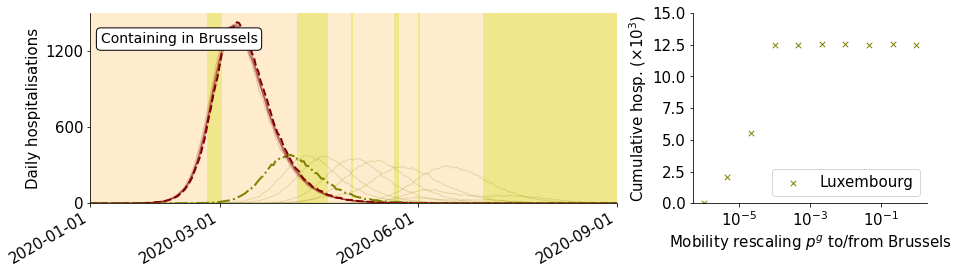

In [5]:
# Slice at nch = 1
nch_value = 1.0

###################
## Figure layout ##
###################

color_NIS1 = 'maroon'
color_NIS2 = 'olive'

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)

from matplotlib import gridspec as gs
fig = plt.figure(figsize=(15,3.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[9, 4]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ticklabelsize = 12
ax0.set_xlim(start_date, end_show)
# ax0.set_xlim(start_date, end_date)
ax0.set_ylim(0, 1300)
ax0.set_yticks([0, 600, 1200])
# ax0.set_ylim(0, 3250)

week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
color_timeframes(start_date, end_date, ax=ax0, week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

xticks=[pd.Timestamp(2020, 1, 1).date(), pd.Timestamp(2020, 3, 1).date(), pd.Timestamp(2020, 6, 1).date(), \
               pd.Timestamp(2020, 9, 1).date()]

##########################
## Actual visualization ##
##########################

for i, init_number in enumerate(init_numbers):
    
    # initialise sum array
    sum_array_NIS1 = []
    sum_array_NIS2 = []
    
    for j,pg_value in enumerate(pg_values):
        
        ################################
        ## Compute additional metrics ##
        ################################
        
        # Slice output
        out = results[str(init_number)][str(pg_value)][str(nch_value)]
        
        # Attach to results
        sum_NIS1 = float(out.sel(NIS=NIS1).sum().values)
        sum_array_NIS1.append(sum_NIS1)
        sum_NIS2 = float(out.sel(NIS=NIS2).sum().values)
        sum_array_NIS2.append(sum_NIS2)
        
        ################
        ## Left panel ##
        ################
        
        # Plot only first initial_numbers values
        if i == 0:
            if j == 0:
                # Plot original simulation thicker
                out.sel(NIS=NIS1).plot(ax=ax0, color=color_NIS1, label='Brussels',
                                                        linewidth=2, linestyle='--')
                out.sel(NIS=NIS2).plot(ax=ax0, color=color_NIS2, label='Luxembourg',
                                                        linewidth=2, linestyle='-.')
            else:
                # Plot other simulations less thick
                out.sel(NIS=NIS1).plot(ax=ax0, color=color_NIS1, linewidth=1, alpha=0.2)
                out.sel(NIS=NIS2).plot(ax=ax0, color=color_NIS2, linewidth=1, alpha=0.2)
        
    ax0.set_title(None)
    ax0.grid(False)
    ticklabelsize = 14
    ax0.set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
    ax0.set_xlabel(None)
    ax0.set_ylabel('Daily hospitalisations')
    ax0.set_ylim([0,1500])
        
    #################
    ## Right panel ##
    #################     
    
    s=30; linewidth=1
    rescale = 1/1000
    if init_NIS==NIS1:
        ax1.scatter(np.array(pg_values), np.array(sum_array_NIS2)*rescale, s=s, color=color_NIS2, marker='x', label='Luxembourg', linewidths=linewidth)
    elif init_NIS==NIS2:
        ax1.scatter(np.array(pg_values), np.array(sum_array_NIS1)*rescale, s=s, color=color_NIS1, marker='x', label='Brussels', linewidths=linewidth)
    
    ax1.set_xscale('linear')
    ax1.set_xlabel(f'Mobility rescaling $p^g$ to/from Brussels')
    ax1.set_ylabel('Cumulative hosp. ($\\times10^3$)')
    ax1.set_xscale('log')
    ax1.grid(False)
        
################
## Formatting ##
################

if init_NIS==NIS2:
    ax0.text(0.02, 0.90, 'Shielding Brussels', transform=ax0.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    arrow_start = start_date + pd.Timedelta(days=10)
    arrow_end = start_date + pd.Timedelta(days=120)
    arrow_height = 600
    #ax0.annotate(text='decreasing $p^g$', xytext=(arrow_start, arrow_height+200), xy=(arrow_end, arrow_height-350), \
    #            arrowprops=dict(arrowstyle='->', linewidth=2, color=color_NIS1))#, ls='dashed'))
    ax1.set_ylim([0,50])
    ax1.legend(loc=4)
    
elif init_NIS==NIS1:
    ax0.text(0.02, 0.90, 'Containing in Brussels', transform=ax0.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    arrow_start1 = start_date + pd.Timedelta(days=54)
    arrow_end1 = start_date + pd.Timedelta(days=55)
    arrow_start2 = start_date + pd.Timedelta(days=95)
    arrow_end2 = start_date + pd.Timedelta(days=150)
    #ax0.annotate(text='', xytext=(arrow_start1, 320), xy=(arrow_end1, 530), \
    #            arrowprops=dict(arrowstyle='->', linewidth=2, color=color_NIS1))#, ls='dashed'))
    #ax0.annotate(text='decreasing $p^g$', xytext=(arrow_start2, 450), xy=(arrow_end2, 480), \
    #            arrowprops=dict(arrowstyle='->', linewidth=2, color=color_NIS2))#, ls='dashed'))
    ax1.set_ylim([0,15])
    ax1.legend(loc=4)

if savefig:
    plt.savefig(f"mobility-reduction-in-{NIS1}_index-patients-in-{init_NIS}.pdf", bbox_inches='tight')
    
plt.show()
plt.close() 

## Make 1D $n_c^{h}$ figure

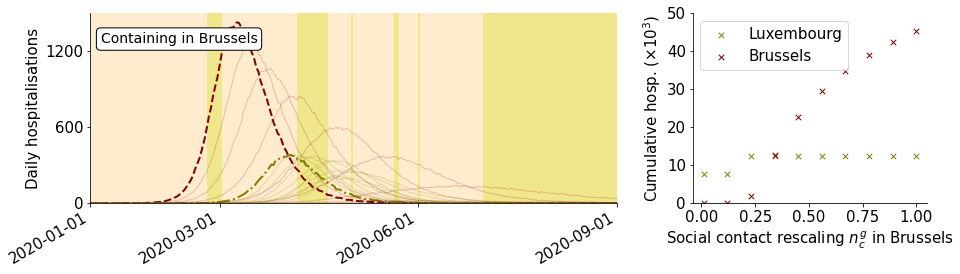

In [27]:
# Slice at pg = 1
pg_value = 1.0

###################
## Figure layout ##
###################

color_NIS1 = 'maroon'
color_NIS2 = 'olive'

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='white', alpha=1)

from matplotlib import gridspec as gs
fig = plt.figure(figsize=(15,3.5))
gs = gridspec.GridSpec(1, 2, width_ratios=[9, 4]) 
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1])

ticklabelsize = 12
ax0.set_xlim(start_date, end_show)
# ax0.set_xlim(start_date, end_date)
ax0.set_ylim(0, 1300)
ax0.set_yticks([0, 600, 1200])
# ax0.set_ylim(0, 3250)

week_color='blanchedalmond'#'white'
weekend_color='blanchedalmond'#'lightgrey'
vacation_color='khaki'#weekend_color
color_timeframes(start_date, end_date, ax=ax0, week_color=week_color, weekend_color=weekend_color, vacation_color=vacation_color)

xticks=[pd.Timestamp(2020, 1, 1).date(), pd.Timestamp(2020, 3, 1).date(), pd.Timestamp(2020, 6, 1).date(), \
               pd.Timestamp(2020, 9, 1).date()]

##########################
## Actual visualization ##
##########################

for i, init_number in enumerate(init_numbers):
    
    # initialise sum array
    sum_array_NIS1 = []
    sum_array_NIS2 = []
    
    for j,nch_value in enumerate(nch_values):
        
        ################################
        ## Compute additional metrics ##
        ################################
        
        # Slice output
        out = results[str(init_number)][str(pg_value)][str(nch_value)]
        
        # Attach to results
        sum_NIS1 = float(out.sel(NIS=NIS1).sum().values)
        sum_array_NIS1.append(sum_NIS1)
        sum_NIS2 = float(out.sel(NIS=NIS2).sum().values)
        sum_array_NIS2.append(sum_NIS2)
        
        ################
        ## Left panel ##
        ################
        
        # Plot only first initial_numbers values
        if i == 0:
            if j == 0:
                # Plot original simulation thicker
                out.sel(NIS=NIS1).plot(ax=ax0, color=color_NIS1, label='Brussels',
                                                        linewidth=2, linestyle='--')
                out.sel(NIS=NIS2).plot(ax=ax0, color=color_NIS2, label='Luxembourg',
                                                        linewidth=2, linestyle='-.')
            else:
                # Plot other simulations less thick
                out.sel(NIS=NIS1).plot(ax=ax0, color=color_NIS1, linewidth=1, alpha=0.2)
                out.sel(NIS=NIS2).plot(ax=ax0, color=color_NIS2, linewidth=1, alpha=0.2)
        
    ax0.set_title(None)
    ax0.grid(False)
    ticklabelsize = 14
    ax0.set_xticks(ticks=xticks, rotation=0, size=ticklabelsize, ha='center')
    ax0.set_xlabel(None)
    ax0.set_ylabel('Daily hospitalisations')
    ax0.set_ylim([0,1500])
        
    #################
    ## Right panel ##
    #################     
    
    s=30; linewidth=1
    rescale = 1/1000
    #f init_NIS==NIS1:
    ax1.scatter(np.array(nch_values), np.array(sum_array_NIS2)*rescale, s=s, color=color_NIS2, marker='x', label='Luxembourg', linewidths=linewidth)
    #lif init_NIS==NIS2:
    ax1.scatter(np.array(nch_values), np.array(sum_array_NIS1)*rescale, s=s, color=color_NIS1, marker='x', label='Brussels', linewidths=linewidth)
    
    ax1.set_xscale('linear')
    ax1.set_xlabel(f'Social contact rescaling $n_c^g$ in Brussels')
    ax1.set_ylabel('Cumulative hosp. ($\\times10^3$)')
    ax1.grid(False)
        
################
## Formatting ##
################

if init_NIS==NIS2:
    ax0.text(0.02, 0.90, 'Shielding Brussels', transform=ax0.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    arrow_start = start_date + pd.Timedelta(days=10)
    arrow_end = start_date + pd.Timedelta(days=120)
    arrow_height = 600
    #ax0.annotate(text='decreasing $p^g$', xytext=(arrow_start, arrow_height+200), xy=(arrow_end, arrow_height-350), \
    #            arrowprops=dict(arrowstyle='->', linewidth=2, color=color_NIS1))#, ls='dashed'))
    ax1.set_ylim([0,50])
    ax1.legend(loc=4)
    
elif init_NIS==NIS1:
    ax0.text(0.02, 0.90, 'Containing in Brussels', transform=ax0.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
    arrow_start1 = start_date + pd.Timedelta(days=54)
    arrow_end1 = start_date + pd.Timedelta(days=55)
    arrow_start2 = start_date + pd.Timedelta(days=95)
    arrow_end2 = start_date + pd.Timedelta(days=150)
    #ax0.annotate(text='', xytext=(arrow_start1, 320), xy=(arrow_end1, 530), \
    #            arrowprops=dict(arrowstyle='->', linewidth=2, color=color_NIS1))#, ls='dashed'))
    #ax0.annotate(text='decreasing $p^g$', xytext=(arrow_start2, 450), xy=(arrow_end2, 480), \
    #            arrowprops=dict(arrowstyle='->', linewidth=2, color=color_NIS2))#, ls='dashed'))
    ax1.set_ylim([0,50])
    ax1.legend(loc=0)

# fig.suptitle("Effect of manipulating mobility to/from Brussels")
if savefig:
    plt.savefig(f"contact-reduction-in-{NIS1}_index-patients-in-{init_NIS}.pdf", bbox_inches='tight')
    
plt.show()
plt.close()